# Results processing and data viz
## From mesoscopic experiments. Trial 01

It includes some preeliminary plots, the summary plots, and the creation of grid maps and animations

Params:

$\tau_{ff} = 1$

$\tau_{fj} = 1.2$

$\tau_{jf} = 1.8$

$\tau_{jj} = 1.4$

--meso-tls-penalty = 2

In [1]:
#imports
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 16})
pd.set_option('display.max_rows', 3000)

#Make sure that the SUMO_HOME environment variable is correctly set after installation:
SUMO_HOME = r"C:\Program Files (x86)\Eclipse\Sumo"

## Source results files

In [2]:
results_folder_net01 = r"net01/data/results_meso_trial01/"
results_folder_net02 = r"net02/data/results_meso_trial01/"
results_folder_net03 = r"net03/data/results_meso_trial01/"
results_folder_net04 = r"net04/data/results_meso_trial01/"

## Visualization of performance of each network 
## (optional)
Some quick visualizations can be optionally created for checking how each network behaves with the increasing levels of traffic with the scaling factors. Then, the point of optimal functioning of the network can be identified by checking when these networks minimum average speed drops. It is an indicator of the saturation of the network.

In [3]:
# Transforming summary files from xml to csv

def transform_summary_xml_to_csv(results_folder):
    if not os.path.exists(results_folder + r"/csv"):
        os.makedirs(results_folder + r"/csv")

    for file in os.listdir(results_folder):
        if file.endswith("summary.xml"):
            input_xml_file = str(results_folder + file)
            output_csv_file = str(results_folder + r"/csv/" + file[:-3] + "csv")
            # bash command
            !python "$SUMO_HOME\tools\xml\xml2csv.py" \
            --output "{output_csv_file}" \
            "{input_xml_file}"
            
# Building new pandas dataframe based on summary data from the results summary csv files

def create_pandas_df_summary(results_folder):
    total_veh_ref = 315000

    #new pandas dataframe
    column_names = ['scale', 'loaded_veh', 'min_avg_speed', 'mean_avg_speed', 'max_avg_speed', 'max_veh_running']
    df_summary = pd.DataFrame(columns = column_names)

    for file in os.listdir(results_folder + "/csv/"):
        if file.endswith("summary.csv"):
            output_csv_file = str(results_folder + r"/csv/" + file)
            df = pd.read_csv(output_csv_file, sep=";")
            df.index = pd.to_datetime(df.index, unit='s')
            df_5min = df.resample('5T').mean()
            scale =  float(output_csv_file.split('_')[-2])
            loaded_veh = scale*total_veh_ref
            min_avg_speed = df_5min['step_meanSpeed'].min()
            mean_avg_speed = df_5min['step_meanSpeed'].mean()
            max_avg_speed = df_5min['step_meanSpeed'].max()
            max_veh_running = df_5min['step_running'].max()

            df_summary.loc[len(df_summary.index)] = [scale, 
                                                     loaded_veh, 
                                                     min_avg_speed, 
                                                     mean_avg_speed, 
                                                     max_avg_speed, 
                                                     max_veh_running]
    return df_summary

In [4]:
transform_summary_xml_to_csv(results_folder_net01)
transform_summary_xml_to_csv(results_folder_net02)
transform_summary_xml_to_csv(results_folder_net03)
transform_summary_xml_to_csv(results_folder_net04)

df_compar_net01 = create_pandas_df_summary(results_folder_net01)
df_compar_net02 = create_pandas_df_summary(results_folder_net02)
df_compar_net03 = create_pandas_df_summary(results_folder_net03)
df_compar_net04 = create_pandas_df_summary(results_folder_net04)

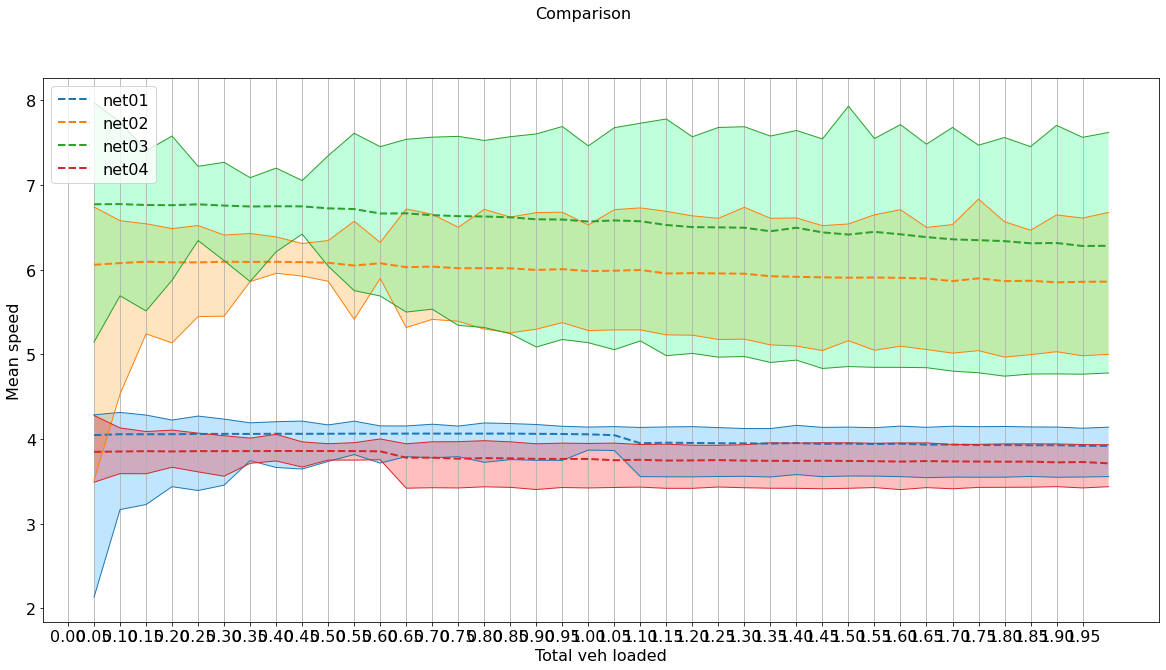

In [5]:
colors_list_01 = cm.jet(np.linspace(0,1,10))

fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle('Comparison', fontsize=16)

list = [df_compar_net01, df_compar_net02, df_compar_net03, df_compar_net04]
names = ['net01', 'net02', 'net03', 'net04']
line_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
shade_color = [(0,0.6,1,0.25), (1,0.6,0,0.25), (0,1,0.45,0.25), (1,0,0,0.25)]
for i in range(len(list)):
    df = list[i]
    ax.plot(df['scale'], df['mean_avg_speed'], color=line_colors[i], lw=2, linestyle='dashed', label=names[i])
    down = ax.plot(df['scale'], df['min_avg_speed'], color=line_colors[i], lw=1)
    top = ax.plot(df['scale'], df['max_avg_speed'], color=line_colors[i], lw=1)
    ax.fill_between(df['scale'], df['max_avg_speed'], df['min_avg_speed'], facecolor=shade_color[i])

plt.ylabel('Mean speed')
plt.xlabel('Total veh loaded')
ax.legend(loc="upper left")
plt.xticks(np.arange(0, 2, step=0.05))
ax.xaxis.grid(True)

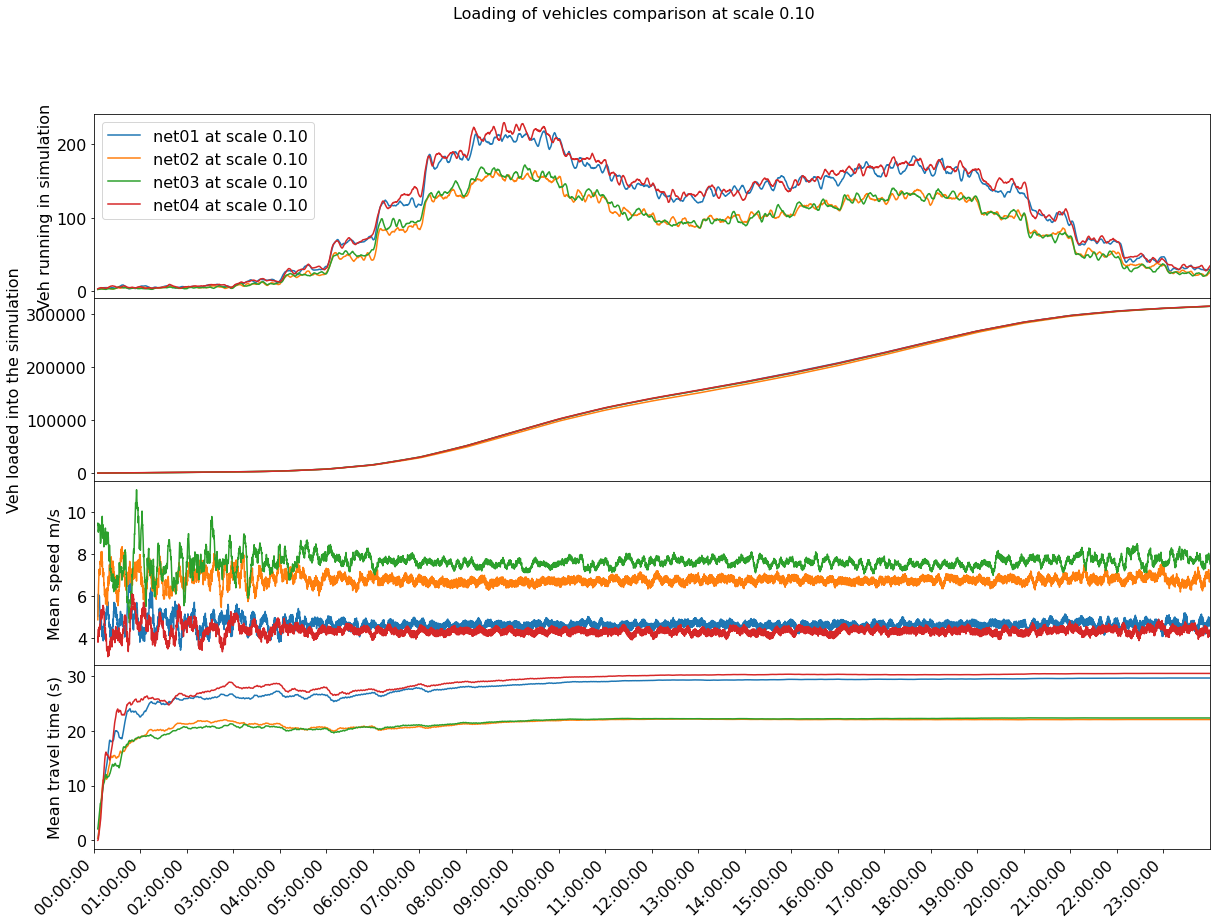

In [6]:
scale = "0.10"
experiments = ['net01', 'net02', 'net03', 'net04']

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,15), sharex=True, 
                       gridspec_kw={'hspace': 0, 'wspace': 0})
fig.suptitle('Loading of vehicles comparison at scale {}'.format(scale), fontsize=16)

for exp in experiments:
    output_csv_file = r"{}\data\results\csv\scale_{}_summary.csv".format(exp, scale)
    df = pd.read_csv(output_csv_file, sep=";")
    df.index = pd.to_datetime(df.index, unit='s')
    ax[0].plot(df.index, df['step_running'].rolling(window=300).mean(), label="{} at scale {}".format(exp, scale))
    ax[1].plot(df.index, df['step_ended'].rolling(window=300).mean(), label="{} at scale {}".format(exp, scale))
    ax[2].plot(df.index, df['step_meanSpeed'].rolling(window=300).mean(), label="{} at scale {}".format(exp, scale))
    ax[3].plot(df.index, df['step_meanTravelTime'].rolling(window=300).mean(), label="{} at scale {}".format(exp, scale))
    
ax[0].xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax[0].set_ylabel('Veh running in simulation')
ax[1].set_ylabel('Veh loaded into the simulation')
ax[2].set_ylabel('Mean speed m/s')
ax[3].set_ylabel('Mean travel time (s)')
ax[0].legend(loc="upper left")
ax[0].set_xlim(df.index.min(),df.index.max())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.autofmt_xdate(rotation=45)

## Traffic fundamental diagram
Network metrics are needed for normalizing the results accross the different networks.

In [7]:
#Total length of lanes for the different networks
#These values are obtained manually from the nets, using SUMO-GUI and NETEDIT
net_length_net01 = 53920

net_length_net02_x2lanes = 2456.6 + 2516.6 + 2943.12 + 929.84 + 955.44 + 506.52 + 5373.72 + 4629.2 + 2854.32 + 1038.64 + 1503.96 + 507.32 + 504.52
net_length_net02_x1lanes = 504.32 + 979.04 + 475.72 + 490.52 + 754.98 + 965.24 + 1904.88 + 1851.68 + 978.04 + 964.24
net_length_net02 = net_length_net02_x2lanes + net_length_net02_x1lanes

net_length_net03_x2lanes = 21186.08
net_length_net03_x1lanes = 7263.8 + 5811.04
net_length_net03 = net_length_net03_x2lanes + net_length_net03_x1lanes

net_length_net04 = 58918.52


# Num of edges per network
num_edges_net01 = 220
num_edges_net02 = 192
num_edges_net03 = 196
num_edges_net04 = 242

Helper functions for transforming the original XML files that SUMO creates as results of the simulation into CSV files and then dataframes.

In [8]:
# Helper function for transforming XLM output files into 

def transform_aadt_output_xml_to_csv(results_folder):
    if not os.path.exists(results_folder + r"/csv"):
        os.makedirs(results_folder + r"/csv")

    for file in os.listdir(results_folder):
        if file.endswith("aadt_output_freq60s.xml"):
            input_xml_file = str(results_folder + file)
            output_csv_file = str(results_folder + r"/csv/" + file[:-3] + "csv")
            # bash command
            !python "$SUMO_HOME\tools\xml\xml2csv.py" \
            --output "{output_csv_file}" \
            "{input_xml_file}"

# Building new pandas dataframe based on summary data from the results summary csv files

def create_df_for_traffic_fundamental_diagram(results_folder, net_length, num_edges):
    
    column_names = ['experiment', 'scale', 'lanes_length_m', 'flow', 'density', 'freq', 'edge_entered', 'edge_departed', 'edge_sampledSeconds']
    df_output = pd.DataFrame(columns = column_names)
    #iterate through the folder
    for file in os.listdir(results_folder + "/csv/"):
        if file.endswith("aadt_output_freq60s.csv"):
            output_csv_file =  str(results_folder + r"/csv/" + file)
            scale = float(output_csv_file.split('_')[-5])
            experiment = results_folder.split('/')[0]
            freq = 60
            #transform to pandas df
            df = pd.read_csv(output_csv_file, sep=";")
            #groupby
            df_g = df.groupby('interval_begin')[['edge_entered', 'edge_departed', 'edge_sampledSeconds']].apply(sum)
            #create variables of fundamental traffic diagram (#some refs: https://www.eclipse.org/lists/sumo-user/msg06970.html)
            df_g['scale'] = scale
            df_g['lanes_length_m'] = net_length
            df_g['flow'] = (((df_g.edge_entered + df_g.edge_departed)/freq)*3600)/num_edges #maybe freq here no TODO!!!!!
            df_g['density'] = (df_g.edge_sampledSeconds/freq)/(net_length/1000)
            df_g['experiment'] = experiment
            df_g['freq'] = freq
            #merge
            frames = [df_output, df_g]
            df_output = pd.concat(frames)
    
    return df_output

Helper functions for smoothing the data and obtaining the critical points of the fundamental diagram.

In [9]:
from scipy.interpolate import pchip
import statsmodels.api as sm
from operator import itemgetter

# COMBINING PCHIP AND LOWESS
def fit(x,y):
    
    pch = pchip(x, y)
    
    xx = np.linspace(x[0], x[-1], 1000)
    yy = pch(xx)
    
    lowess = sm.nonparametric.lowess(yy, xx, frac=0.2)
    
    x_lowess = lowess[:, 0]
    y_lowess = lowess[:, 1]
    return [x_lowess, y_lowess]


def estimate_critical_metrics(exp_df):
    
    exp_df_mod = exp_df.groupby('density').mean()
    exp_df_mod = exp_df_mod.sort_index()
    
    x = exp_df_mod.index
    y = exp_df_mod.flow

    [x2, y2] = fit(x, y)
    
    max_flow = max(y2)
    density_at_max_flow = x2[y2.argmax()]
    estimated_optimal_speed = (max_flow/density_at_max_flow) 
    return (max_flow, density_at_max_flow, estimated_optimal_speed, x2, y2)

def create_df_critical_metrics():
    
    column_names = ['experiment', 'lanes_length_m', 'max_flow', 'density_At_max_flow', 'optim_speed']
    df_compa = pd.DataFrame(columns = column_names)
    
    for df_exp in [df_tdf_002, df_tdf_032, df_tdf_052, df_tdf_102]:
        critical_metrics = estimate_critical_metrics(df_exp)
        df_compa.loc[len(df_compa.index)] = [df_exp.experiment.iloc[0], 
                                             df_exp.lanes_length_m.iloc[0], 
                                             critical_metrics[0], 
                                             critical_metrics[1], 
                                             critical_metrics[2]]
    
    return df_compa

In [10]:
transform_aadt_output_xml_to_csv(results_folder_net01)
transform_aadt_output_xml_to_csv(results_folder_net02)
transform_aadt_output_xml_to_csv(results_folder_net03)
transform_aadt_output_xml_to_csv(results_folder_net04)

df_tdf_002 = create_df_for_traffic_fundamental_diagram(results_folder_net01, net_length_net01, num_edges_net01)
df_tdf_032 = create_df_for_traffic_fundamental_diagram(results_folder_net02, net_length_net02, num_edges_net02)
df_tdf_052 = create_df_for_traffic_fundamental_diagram(results_folder_net03, net_length_net03, num_edges_net03)
df_tdf_102 = create_df_for_traffic_fundamental_diagram(results_folder_net04, net_length_net04, num_edges_net04)

In [11]:
df_critical_metrics = create_df_critical_metrics()
df_critical_metrics

,experiment,lanes_length_m,max_flow,density_At_max_flow,optim_speed
0,net01,53920,1130.912050,46.452150,24.345742
1,net02,36588.5,862.688930,29.703701,29.043147
2,net03,34260.9,797.903041,28.385669,28.109362
3,net04,58918.5,664.229375,28.020559,23.705072


## Viz
Basic fundamental diagrams comparison

In [12]:
# Make directory for comparative fundamental diagrams
if not os.path.exists(r"charts"):
    os.makedirs(r"charts")

<ipython-input-15-938b2ed2040d>:26: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD01_compar_01-02-03-04_meso01.png",


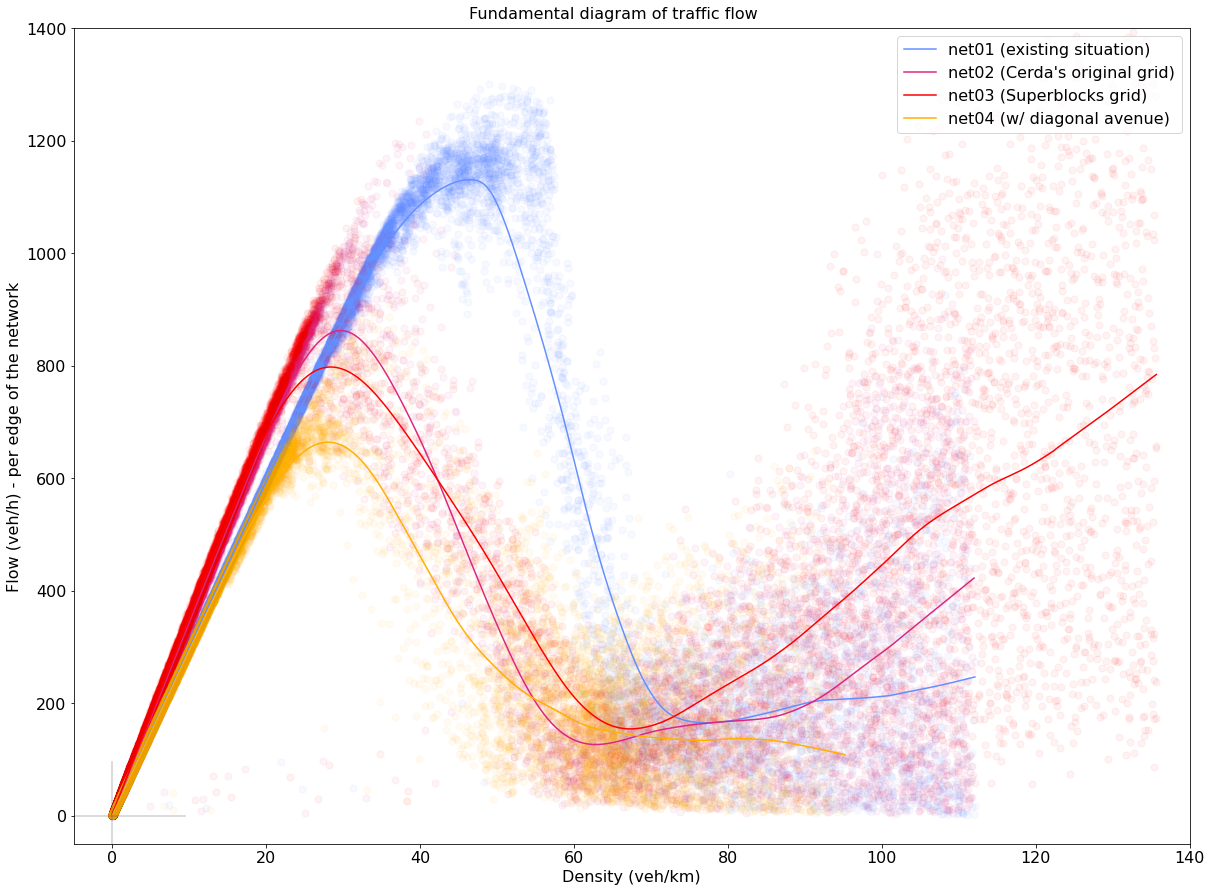

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,15), sharex=True, 
                       gridspec_kw={'hspace': 0, 'wspace': 0})

fig.suptitle('Fundamental diagram of traffic flow', fontsize=16, y=0.9)
col = ["#648FFF", "#DC267F", "#FE0000", "#FFB000"]
# col = ["#9b7000", "#23d980", "#01ffff", "#004fff"] #INVERT

ax.scatter(df_tdf_002.density, df_tdf_002['flow'], color=col[0], s=50, alpha=0.05)
ax.scatter(df_tdf_032.density, df_tdf_032['flow'], color=col[1], s=50, alpha=0.05)
ax.scatter(df_tdf_052.density, df_tdf_052['flow'], color=col[2], s=50, alpha=0.05)
ax.scatter(df_tdf_102.density, df_tdf_102['flow'], color=col[3], s=50, alpha=0.05)

ax.plot(estimate_critical_metrics(df_tdf_002)[3], estimate_critical_metrics(df_tdf_002)[4], color=col[0], label="net01 (existing situation)")
ax.plot(estimate_critical_metrics(df_tdf_032)[3], estimate_critical_metrics(df_tdf_032)[4], color=col[1], label="net02 (Cerda's original grid)")
ax.plot(estimate_critical_metrics(df_tdf_052)[3], estimate_critical_metrics(df_tdf_052)[4], color=col[2], label="net03 (Superblocks grid)")
ax.plot(estimate_critical_metrics(df_tdf_102)[3], estimate_critical_metrics(df_tdf_102)[4], color=col[3], label="net04 (w/ diagonal avenue)")

ax.set_ylabel('Flow (veh/h) - per edge of the network')
ax.set_xlabel('Density (veh/km)')
ax.legend(loc="upper right")
ax.set_xlim(-5,140)
ax.set_ylim(-50,1400)
ax.axhline(y=0, xmin=-0.05, xmax=0.1, color=(0.25, 0.25, 0.25, 0.25))
ax.axvline(x=0, ymin=-0.05, ymax=0.1, color=(0.25, 0.25, 0.25, 0.25))

fig.savefig("charts/MFD01_compar_01-02-03-04_meso_trial01.png",
        orientation='portrait',
        transparent=True, bbox_inches='tight', pad_inches=0,
        frameon=None, metadata=None)

Fundamental diagram comparison with scale values for each simulation

<ipython-input-16-8ae067ba5add>:32: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  fig.savefig("charts/MFD02_compar_01-02-03-04_meso01.png", dpi=None, facecolor='w', edgecolor='w',


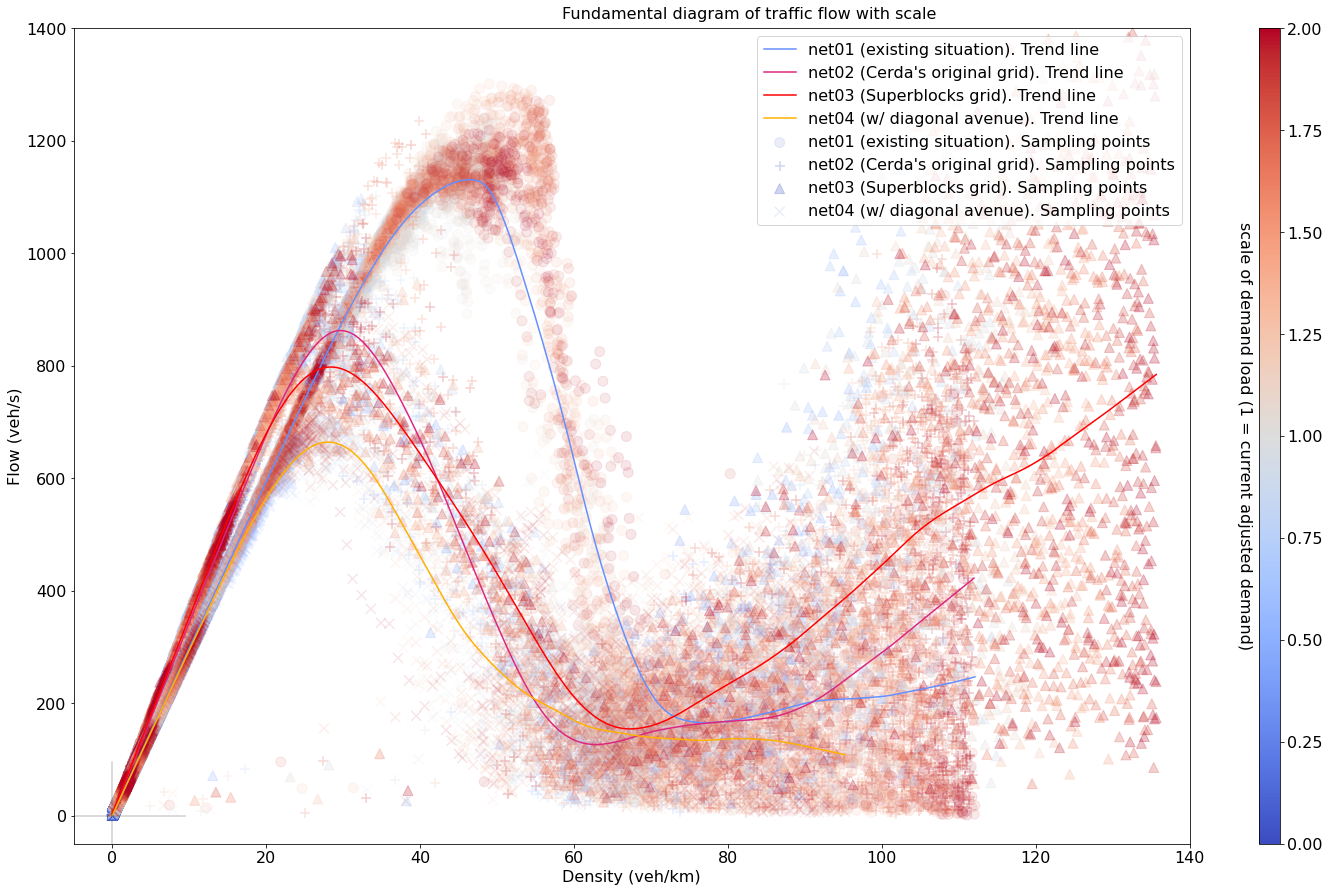

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15), sharex=True, 
                       gridspec_kw={'hspace': 0, 'wspace': 0})

color_002 = cm.get_cmap('coolwarm')

fig.suptitle('Fundamental diagram of traffic flow with scale', fontsize=16, y=0.9)

ax.scatter(df_tdf_002.density, df_tdf_002['flow'], marker='o', s=100, alpha=0.1, color=color_002(df_tdf_002.scale/2), label="net01 (existing situation). Sampling points")
ax.scatter(df_tdf_032.density, df_tdf_032['flow'], marker='+', s=100, alpha=0.25, color=color_002(df_tdf_032.scale/2), label="net02 (Cerda's original grid). Sampling points")
ax.scatter(df_tdf_052.density, df_tdf_052['flow'], marker='^', s=100, alpha=0.25, color=color_002(df_tdf_052.scale/2), label="net03 (Superblocks grid). Sampling points")
ax.scatter(df_tdf_102.density, df_tdf_102['flow'], marker='x', s=100, alpha=0.1, color=color_002(df_tdf_102.scale/2), label="net04 (w/ diagonal avenue). Sampling points")

ax.plot(estimate_critical_metrics(df_tdf_002)[3], estimate_critical_metrics(df_tdf_002)[4], color=col[0], label="net01 (existing situation). Trend line")
ax.plot(estimate_critical_metrics(df_tdf_032)[3], estimate_critical_metrics(df_tdf_032)[4], color=col[1], label="net02 (Cerda's original grid). Trend line")
ax.plot(estimate_critical_metrics(df_tdf_052)[3], estimate_critical_metrics(df_tdf_052)[4], color=col[2], label="net03 (Superblocks grid). Trend line")
ax.plot(estimate_critical_metrics(df_tdf_102)[3], estimate_critical_metrics(df_tdf_102)[4], color=col[3], label="net04 (w/ diagonal avenue). Trend line")

ax.set_ylabel('Flow (veh/s)')
ax.set_xlabel('Density (veh/km)')
ax.legend(loc="upper right")
ax.set_xlim(-5,140)
ax.set_ylim(-50,1400)
ax.axhline(y=0, xmin=-0.05, xmax=0.1, color=(0.25, 0.25, 0.25, 0.25))
ax.axvline(x=0, ymin=-0.05, ymax=0.1, color=(0.25, 0.25, 0.25, 0.25))

cNorm  = colors.Normalize(vmin=0, vmax=2)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=color_002)
scalarMap.set_array([])
cbar = fig.colorbar(scalarMap,ax=ax, aspect=40)
cbar.set_label('scale of demand load (1 = current adjusted demand)', rotation=270,  labelpad=-70)

fig.savefig("charts/MFD02_compar_01-02-03-04_meso_trial01.png", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=0,
        frameon=None, metadata=None)

## Create edge-based visualizations for AADT levels
* Static hourly snapshots for each network scenario at its optimal level of service (depending on the optimal scale or amount of allocated traffic).
* Animation for each network scenario at its optimal level of service.

In [ ]:
import imageio

experiments = ['net01', 'net02', 'net03', 'net04']
net_files = ['grid01-bcn_06.net.xml', 'grid01-bcn_10.net.xml', 'grid01-bcn_50.net.xml', 'grid01-bcn_100.net.xml']
# dump_files = ['scale_1.00_edgedata_aadt_output.xml', 'scale_0.35_edgedata_aadt_output.xml',
#              'scale_0.15_edgedata_aadt_output.xml', 'scale_0.40_edgedata_aadt_output.xml']
dump_files_seq = ['scale_1.00_edgedata_aadt_output_freq60s.xml', 'scale_0.35_edgedata_aadt_output_freq60s.xml',
             'scale_0.15_edgedata_aadt_output_freq60s.xml', 'scale_0.35_edgedata_aadt_output_freq60s.xml']

for i in range(len(experiments)):
    experiment = experiments[i]
    net = net_files[i]
    results_folder = r"results_meso_trial01"
    output_folder_anim = r"imgs\anim"
    output_folder_static = r"imgs\static"
    
    if not os.path.exists(r"{}\data\{}\{}".format(experiment, results_folder, output_folder_anim)):
        os.makedirs(r"{}\data\{}\{}".format(experiment, results_folder, output_folder_anim))
    if not os.path.exists(r"{}\data\{}\{}".format(experiment, results_folder, output_folder_static)):
        os.makedirs(r"{}\data\{}\{}".format(experiment, results_folder, output_folder_static))

    #STATIC IMAGE AS SUMMARY
    # iterate through the files
    for file in os.listdir(r"{}\data\{}".format(experiment, results_folder)):
        if file.endswith("aadt_output.xml"):
            dump = file
    
            NET_FILE = r"{}\data\{}".format(experiment, net)
            DUMP_FILE = r"{}\data\{}\{}".format(experiment, results_folder, dump) #the results folder changes depending on the simulation framework run (MESO vs SUMO)
            OUTPUT_FILE_STATIC = r"{}\data\{}\{}\{}.png".format(experiment, results_folder, output_folder_static, dump)

            #static
            !python "$SUMO_HOME\tools\visualization\plot_net_dump.py" -v \
            -n "{NET_FILE}" \
            -i "{DUMP_FILE}","{DUMP_FILE}" \
            --measures sampledSeconds,sampledSeconds \
            --xticks 0 --yticks 0 \
            --default-color #ffffff00 --default-width 3 \
            --max-width 5 --min-width .1  \
            --colormap #0:#577590,.25:#90be6d,.5:#f9c74f,.75:#f8961e,1:#f94144 \
            -o "{OUTPUT_FILE_STATIC}"
    
    #ANIMATION
    # creating png frames
    dump_seq = dump_files_seq[i] 
    NET_FILE = r"{}\data\{}".format(experiment, net)
    DUMP_FILE_SEQ = r"{}\data\{}\{}".format(experiment, results_folder, dump_seq)
    OUTPUT_FILE_ANIM = r"{}\data\{}\{}\{}_%05d.png".format(experiment, results_folder, output_folder_anim, dump_seq)
    
    !python "$SUMO_HOME\tools\visualization\mpl_dump_onNet2.py" -v \
    -n "{NET_FILE}" \
    -d "{DUMP_FILE_SEQ}" \
    --value sampledSeconds,sampledSeconds \
    --color-map 0:#577590,.25:#90be6d,.5:#f9c74f,.75:#f8961e,1:#f94144 \
    --default-color #ffffff00 \
    --size 6,6 \
    -o "{OUTPUT_FILE_ANIM}"
    
    #create gif
    images = []
    anim_folder = r"{}\data\{}\{}".format(experiment, results_folder, output_folder_anim)
    output_gif_file = r"{}\data\{}\{}\MOVIE_{}.gif".format(experiment, results_folder, output_folder_anim, dump_seq)
    for file in os.listdir(anim_folder):
        if file.endswith(".png"):
            filename = r"{}\{}".format(anim_folder, file)
            images.append(imageio.imread(filename))
    print("SAVING GIF OF EXPERIMENT {} IN {}".format(experiment,output_gif_file))
    imageio.mimsave(output_gif_file, images, format='GIF', fps=60)
    print('OPTIMIZING')
    print(output_gif_file)
    
    OPTIMIZED_GIF = "{}_{}".format(output_gif_file[:-4], "OPT.gif")
    !C:/gifsicle/gifsicle.exe \
    -O "{output_gif_file}" \
    -o "{OPTIMIZED_GIF}" \
    --colors 256